In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# from HelperFunctions import minibatch 
%reload_ext autoreload
%autoreload 2
from HelperFunctions import minibatch, dummify_columns, undummify, feature_standardize, label_encode_column, columns_of_type

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [2]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, AdaBoostRegressor
randomForest = RandomForestRegressor()
gbm = GradientBoostingRegressor()
abr = AdaBoostRegressor()
from xgboost import XGBRegressor
xgb = XGBRegressor()
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

In [3]:
df=pd.read_csv('down_sampled_df_v2.csv')

In [4]:
drop_list=['id','sub_grade','issue_d','loan_status','zip_code','addr_state']
df.drop(drop_list,axis=1,inplace=True)

In [5]:
df[df.isnull().any(axis=1)]

,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,credit_age_years,mths_since_last_delinq,mths_since_last_derog_record,derog_records,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,collection_amt,install_util,all_util,rev_credit,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mths_since_RecentAcc_opened,all_accs_120days+_PastDue_ever,accs_90days+_PastDue_24m,accs_opened_past_12m,pct_acc_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_credit,install_credit,fico,Outstanding_mortgage_debt,revol_frac,install_frac,mort_frac,card_frac,active_card_frac,active_revol_frac,active_install_frac,open_revol_frac,good_acc_frac,loan_duration,return_rate,RANDOM


In [6]:
df.describe()

,funded_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,credit_age_years,mths_since_last_delinq,mths_since_last_derog_record,derog_records,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,collection_amt,install_util,all_util,rev_credit,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mths_since_RecentAcc_opened,all_accs_120days+_PastDue_ever,accs_90days+_PastDue_24m,accs_opened_past_12m,pct_acc_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_credit,install_credit,fico,Outstanding_mortgage_debt,revol_frac,install_frac,mort_frac,card_frac,active_card_frac,active_revol_frac,active_install_frac,open_revol_frac,good_acc_frac,loan_duration,return_rate,RANDOM
count,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000,51872.000000
mean,14989.394567,44.528532,15.664073,3.338641,69291.150982,19.509743,0.344174,15.918701,-467.568245,-793.023037,0.245682,54.124060,24.401835,0.019799,-703.606936,0.005417,119.279380,-613.988182,-563.232669,26050.494776,-587.378277,0.010352,16.874345,-39.895223,-46.173215,-46.592034,-44.386027,42.625887,0.152529,0.058991,138063.338429,37704.587542,690.419995,68234.281385,-46.110105,-46.369691,-32.973094,-46.162979,-49.060477,-46.261435,-600.496978,-46.104969,-37.849568,19.269382,-0.176470,0.502379
std,8786.682794,11.487012,4.897168,2.866926,37876.876701,11.052047,0.916881,7.427555,516.565436,421.883920,0.708653,37.813884,11.843157,0.158107,469.963818,0.078725,881.092781,514.581402,521.876115,21171.479777,492.774899,0.118097,819.500753,212.497857,210.968934,210.872730,211.369072,231.188697,0.402159,0.512787,133481.231741,35415.882652,26.331272,106941.339596,210.978899,210.921423,178.632193,211.012837,217.065134,210.991059,489.341816,211.025701,192.027661,12.450050,0.370134,0.288525
min,1000.000000,36.000000,5.310000,1.000000,0.000000,0.000000,0.000000,0.927778,-999.000000,-999.000000,0.000000,-999.000000,2.000000,0.000000,-999.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000000,-999.000000,-999.000000,642.000000,-19799.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,-1.000000,0.000013
25%,8000.000000,36.000000,12.290000,1.000000,44000.000000,12.910000,0.000000,10.991667,-999.000000,-999.000000,0.000000,37.400000,16.000000,0.000000,-999.000000,0.000000,0.000000,-999.000000,-999.000000,11700.000000,-999.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,89.200000,0.000000,0.000000,40388.750000,11965.750000,672.000000,0.000000,0.440000,0.166667,0.000000,0.411765,0.307692,0.272727,-999.000000,0.444444,0.365079,9.133333,-0.419641,0.251969
50%,13200.000000,36.000000,15.050000,2.000000,60000.000000,18.960000,0.000000,14.458333,3.000000,-999.000000,0.000000,55.800000,23.000000,0.000000,-999.000000,0.000000,0.000000,-999.000000,-999.000000,20800.000000,-999.000000,0.000000,0.000000,5.000000,0.000000,0.000000,2.000000,96.800000,0.000000,0.000000,84518.000000,29747.500000,682.000000,0.000000,0.600000,0.294118,0.031250,0.550000,0.500000,0.428571,-999.000000,0.611111,0.500000,17.233333,0.034233,0.503827
75%,20000.000000,60.000000,18.490000,5.000000,85000.000000,25.530000,0.000000,19.613889,32.000000,-999.000000,0.000000,73.500000,31.000000,0.000000,16.000000,0.000000,0.000000,65.000000,57.000000,34700.000000,1.000000,0.000000,0.000000,9.000000,0.0000

In [7]:
x_train=df.drop(['return_rate'],axis=1)
y_train=df.return_rate

In [8]:
cat_list=columns_of_type(x_train,'string')
cat_list

['grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type']

# Label Encode Dataframe for random forest

In [9]:
label_encoded_df=label_encode_column(x_train,cat_list)
label_encoded_df.sample(10)

,funded_amnt,term,int_rate,emp_length,annual_inc,dti,delinq_2yrs,credit_age_years,mths_since_last_delinq,mths_since_last_derog_record,derog_records,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,collection_amt,install_util,all_util,rev_credit,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mths_since_RecentAcc_opened,all_accs_120days+_PastDue_ever,accs_90days+_PastDue_24m,accs_opened_past_12m,pct_acc_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_credit,install_credit,fico,Outstanding_mortgage_debt,revol_frac,install_frac,mort_frac,card_frac,active_card_frac,active_revol_frac,active_install_frac,open_revol_frac,good_acc_frac,loan_duration,RANDOM,grade,home_ownership,verification_status,purpose,initial_list_status,application_type
37328,9350.0,36,17.86,1,33600.0,22.75,0.0,10.994444,-999.0,-999.0,0.0,55.2,24.0,0.0,-999.0,0.0,110.0,-999.0,-999.0,17900.0,-999.0,0.0,0.0,12.0,0.0,0.0,1.0,100.0,0.0,0.0,33850.0,15950.0,667.0,0.0,0.375000,0.625000,0.000000,0.666667,0.833333,0.555556,-999.000000,0.777778,0.375000,29.400000,0.700553,3,5,1,2,1,0
19362,10000.0,36,13.33,1,45000.0,26.51,0.0,16.402778,-999.0,79.0,1.0,54.5,25.0,0.0,-999.0,0.0,0.0,-999.0,-999.0,18200.0,-999.0,0.0,0.0,6.0,0.0,0.0,2.0,100.0,1.0,0.0,45496.0,27296.0,667.0,0.0,0.760000,0.200000,0.000000,0.421053,0.375000,0.210526,-999.000000,0.421053,0.400000,8.133333,0.118498,2,5,2,1,1,0
3343,6000.0,36,12.12,1,63000.0,10.80,0.0,5.238889,-999.0,-999.0,0.0,76.7,12.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,-999.0,-999.0,677.0,-999.0,-999.000000,-999.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,36.500000,0.531189,1,5,0,2,0,0
39758,14000.0,36,16.49,9,45000.0,13.47,0.0,6.425000,-999.0,-999.0,0.0,39.9,22.0,0.0,-999.0,0.0,0.0,-999.0,-999.0,26500.0,-999.0,0.0,0.0,1.0,0.0,0.0,3.0,100.0,0.0,0.0,32225.0,5725.0,662.0,0.0,0.954545,0.045455,0.000000,0.428571,0.444444,0.333333,-999.000000,0.904762,0.909091,2.066667,0.419061,3,5,1,1,0,0
12839,11000.0,36,13.35,1,55000.0,21.73,0.0,17.416667,-999.0,61.0,2.0,11.5,40.0,0.0,-999.0,0.0,0.0,-999.0,-999.0,32000.0,-999.0,0.0,0.0,2.0,0.0,0.0,2.0,100.0,2.0,0.0,147960.0,57460.0,692.0,34328.0,0.575000,0.375000,0.050000,0.391304,0.222222,0.173913,-999.000000,0.565217,0.400000,3.066667,0.582921,2,1,1,4,0,0
10962,10000.0,36,9.93,1,80000.0,22.04,0.0,16.741667,-999.0,82.0,1.0,45.8,19.0,0.0,-999.0,0.0,0.0,53.0,48.0,62100.0,1.0,0.0,0.0,7.0,0.0,0.0,1.0,100.0,0.0,1.0,88095.0,25995.0,717.0,0.0,0.684211,0.315789,0.000000,0.692308,0.666667,0.538462,0.333333,0.846154,0.684211,5.033333,0.188494,1,1,1,2,0,0
38883,7775.0,36,15.41,9,19020.0,37.10,0.0,21.391667,-999.0,-999.0,0.0,100.2,12.0,0.0,-999.0,0.0,0.0,-999.0,-999.0,8000.0,-999.0,0.0,0.0,27.0,0.0,0.0,0.0,100.0,0.0,0.0,76650.0,19050.0,722.0,47241.0,0.416667,0.166667,0.416667,0.800000,0.500000,0.400000,-999.000000,0.400000,0.333333,34.500000,0.671964,3,1,2,2,0,0
3351,24000.0,36,10.47,1,60000.0,3.06,0.0,31.877778,-999.0,-999.0,0.0,15.9,14.0,0.0,-999.0,0.0,0.0,105.0,51.0,48800.0,3.0,0.0,0.0,9.0,0.0,0.0,1.0,100.0,0.0,0.0,80268.0,31468.0,762.0,0.0,0.428571,0.571429,0.000000,0.666667,0.750000,0.666667,0.750000,0.666667,0.714286,0.000000,0.771548,1,5,1,2,1,0
35744,7200.0,36,17.77,9,105000.0,15.58,0.0,13.277778,-999.0,-999.0,0.0,87.0,20.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,-999.0,-999.0,672.0,-999.0,-999.000000,-999.000000,0.250000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.550000,8.100000,0.694695,3,1,1,2,0,0
2519,7000.0,36,6.92,1,70000.0,13.78,2.0,14.875000,13.0,-999.0,0.0,59.7,15.0,0.0,-999.0,0.0,0.0,-999.0,-999.0,10600.0,-999.0,0.0,0.0,20.0,0.0,0.0,0.0,73.3,0.0,0.0,33632.0,23032.0,682.0,0.0,0.733333,0.266667,0.000000,0.636364,0.857143,0.727273,-999.000000,0.818182,0.666667,35.533333,0.957443,0,5,0,2,1,0


# Standardize Features

In [10]:
final_df=label_encoded_df.apply(lambda x:feature_standardize(x,scaleType='standardize'),axis=0)

In [11]:
# final_df.head()

# Random Forest

In [15]:
def error_model(params):
    regressor = RandomForestRegressor(criterion="mse",
                                      bootstrap=True,
                                      oob_score = False,
                                      n_jobs=-1,
                                      random_state=0,
                                      **params)
    return -1*cross_val_score(regressor, label_encoded_df,
                              y_train,cv=5,n_jobs=-1,scoring='neg_mean_squared_error').mean()

max_depth_range=[5,10,20,40,80]
max_features_range=['auto','sqrt']
min_samples_leaf_range=[3, 4, 5]
min_samples_split_range=[2, 6, 10, 14]
n_estimators_range=[100,250,500,1000]

param_space = {
    'max_depth': max_depth_range,
    'max_features': max_features_range,
    'min_samples_leaf': min_samples_leaf_range,
    'min_samples_split': min_samples_split_range,
    'n_estimators': n_estimators_range}

best = error_model({'max_depth':max_depth_range[0],
                    'max_features':max_features_range[0],
                    'min_samples_leaf':min_samples_leaf_range[0],
                    'min_samples_split':min_samples_split_range[0],
                    'n_estimators':n_estimators_range[0]})
def f(params):
    global best
    error_score = error_model(params)
    if error_score < best:
        best = error_score
    print ('new best:', best, params)
    return {'loss': error_score, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

KeyboardInterrupt: 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

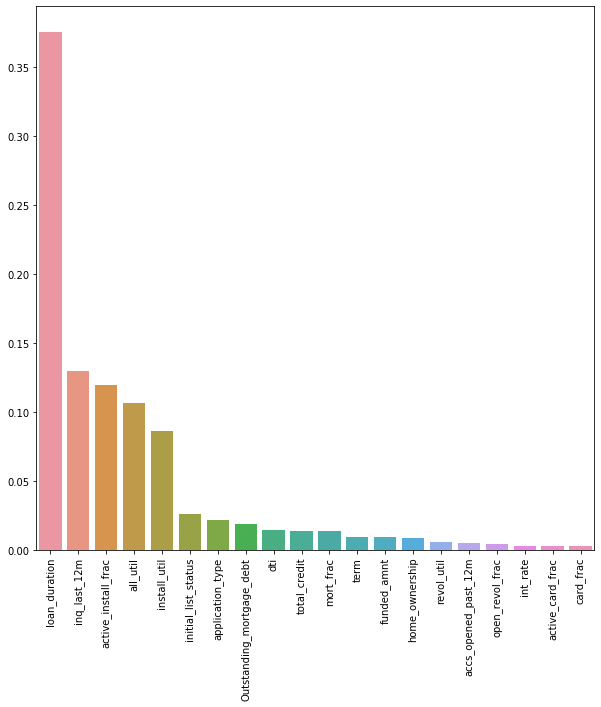

In [14]:
randomForest.set_params(criterion="mse",
                        bootstrap=True,
                        oob_score = False,
                        n_jobs=-1,
                        random_state=0,
                        max_depth=max_depth_range[best['max_depth']],
                        max_features=max_features_range[best['max_features']]),
                        min_samples_leaf_range
                        

max_depth_range=[5,10,20,40,80]
max_features_range=['auto','sqrt']
min_samples_leaf_range=[3, 4, 5]
min_samples_split_range=[2, 6, 10, 14]
n_estimators_range=[100,250,500,1000]



randomForest.fit(label_encoded_df,y_train)
feature_importance=pd.Series(randomForest.feature_importances_,index=label_encoded_df.columns)
feature_importance.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(10,10))
sns.barplot(x=feature_importance.index[0:20],y=feature_importance.values[0:20])
plt.xticks(rotation=90)

# XGBoost

In [29]:
def acc_model(params):
    xgboost = XGBRegressor(n_estimators=100,objective='reg:squarederror', subsample=0.7,seed=0,**params)
    return cross_val_score(xgboost, label_encoded_df, y_train,cv=5).mean()

param_space = {
    'alpha':hp.choice('alpha', np.linspace(0,10,3)),
    'learning_rate':hp.choice('learning_rate', np.linspace(0.1,0.3,3)),
    'max_depth': hp.choice('max_depth', range(3,7)),
    'min_samples_split': hp.choice('min_samples_split', range(3,7))}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=15, trials=trials)
print ('best:')
print (best)

  0%|          | 0/15 [00:00<?, ?it/s, best loss: ?]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                           
0                                                   
{'alpha': 5.0, 'learning_rate': 0.3, 'max_depth': 6, 'min_samples_split': 6}
  7%|▋         | 1/15 [01:13<17:07, 73.38s/it, best loss: 1.0332120538872407]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                    
0                                                                            
{'alpha': 0.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 4} 
 13%|█▎        | 2/15 [01:51<13:36, 62.79s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                    
0                                                                            
{'alpha': 10.0, 'learning_rate': 0.2, 'max_depth': 6, 'min_samples_split': 3}
 20%|██        | 3/15 [03:09<13:26, 67.25s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                    
0                                                                            
{'alpha': 5.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 3} 
 27%|██▋       | 4/15 [03:46<10:40, 58.22s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                    
0                                                                            
{'alpha': 10.0, 'learning_rate': 0.3, 'max_depth': 6, 'min_samples_split': 4}
 33%|███▎      | 5/15 [04:59<10:28, 62.82s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                    
0                                                                            
{'alpha': 0.0, 'learning_rate': 0.3, 'max_depth': 6, 'min_samples_split': 5} 
 40%|████      | 6/15 [06:13<09:55, 66.13s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                    
0                                                                            
{'alpha': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 6} 
 47%|████▋     | 7/15 [07:13<08:33, 64.25s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                    
0                                                                            
{'alpha': 0.0, 'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 4} 
 53%|█████▎    | 8/15 [07:49<06:30, 55.79s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                    
0                                                                            
{'alpha': 5.0, 'learning_rate': 0.3, 'max_depth': 5, 'min_samples_split': 3} 
 60%|██████    | 9/15 [08:48<05:40, 56.80s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                    
0                                                                            
{'alpha': 5.0, 'learning_rate': 0.3, 'max_depth': 4, 'min_samples_split': 3} 
 67%|██████▋   | 10/15 [09:36<04:30, 54.03s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                     
0                                                                             
{'alpha': 5.0, 'learning_rate': 0.3, 'max_depth': 5, 'min_samples_split': 5}  
 73%|███████▎  | 11/15 [10:39<03:46, 56.70s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                     
0                                                                             
{'alpha': 5.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 6}  
 80%|████████  | 12/15 [11:43<02:57, 59.04s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                     
0                                                                             
{'alpha': 10.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_split': 3} 
 87%|████████▋ | 13/15 [12:59<02:08, 64.11s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                     
0                                                                             
{'alpha': 5.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 6}  
 93%|█████████▎| 14/15 [13:48<00:59, 59.62s/it, best loss: 0.7513653260335351]

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data

new best:                                                                     
0                                                                             
{'alpha': 5.0, 'learning_rate': 0.2, 'max_depth': 4, 'min_samples_split': 5}  
100%|██████████| 15/15 [14:35<00:00, 55.60s/it, best loss: 0.7513653260335351]
best:
{'alpha': 0, 'learning_rate': 0, 'max_depth': 0, 'min_samples_split': 1}


In [34]:
best

0

/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/home/auscheng/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

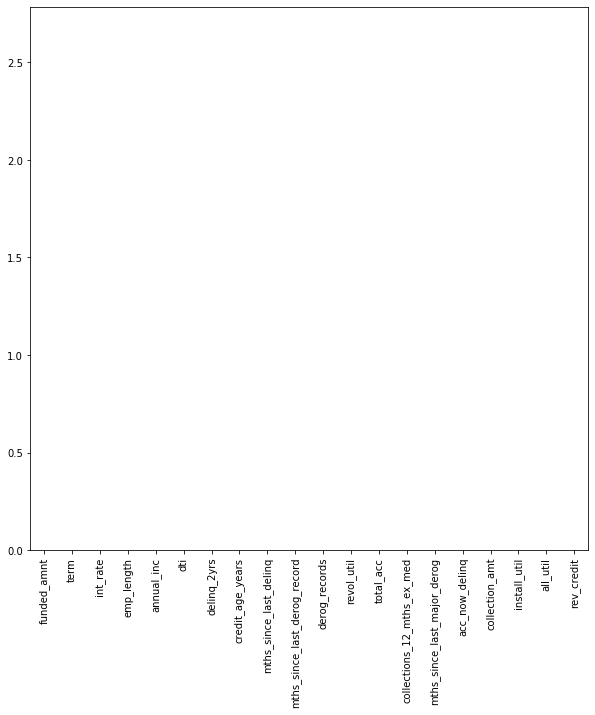

In [30]:
#visualize best predictors
xgb.set_params(n_estimators=100,objective='reg:squarederror', subsample=0.7,seed=0,\
               alpha=best['alpha'],learning_rate=best['learning_rate'],\
               max_depth=best['max_depth'],min_samples_split=best['min_samples_split'])
xgb.fit(label_encoded_df,y_train)
xgb_feature_importance=pd.Series(xgb.feature_importances_,index=label_encoded_df.columns)
xgb_feature_importance.sort_values(ascending=False,inplace=True)
plt.figure(figsize=(10,10))
sns.barplot(x=xgb_feature_importance.index[0:20],y=xgb_feature_importance.values[0:20])
plt.xticks(rotation=90)

# LGBoost

In [33]:
def acc_model(params):
    lgboost = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       **params)
    return cross_val_score(xgboost, label_encoded_df, y_train,cv=5).mean()

param_space = {
    'alpha':hp.choice('alpha', np.linspace(0,10,3)),
    'learning_rate':hp.choice('learning_rate', np.linspace(0.1,0.3,3)),
    'max_depth': hp.choice('max_depth', range(3,7)),
    'min_samples_split': hp.choice('min_samples_split', range(3,7))}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=15, trials=trials)
print ('best:')
print (best)

  0%|          | 0/15 [00:00<?, ?it/s, best loss: ?]


TypeError: type object got multiple values for keyword argument 'learning_rate'